## Ising Model Data Generation
Here, I generate training, validation, and test set data by performing Monte Carlo simulations of the 2-D Ising model at different temperatures and saving the output. 

Each sample configuration is saved as a ```.npy``` (binary numpy file), and consists of an $L$x$L$ matrix with entries taking the values of {-1,1}, indicating spin-up and spin-down, respectively.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import multiprocessing as mp
from itertools import repeat
%matplotlib inline

Set the save locations for each of the data sets.

In [5]:
train_path = '../../data/Ising/train/'
#test_path = '../../data/Ising/test/'
valid_path = '../../data/Ising/valid/'

## Simulation Functions
Below I define functions for the Monte Carlo simulations. Different algorithms can be used for simulating the Ising model. I include funtions based off the Metropolis and Wolff algorithms. I ultimately use the Wolff algoritm to produce the training data. All algorithms assume periodic boundary conditions.

First, this function will create and randomly fill an $L$x$L$ array with 1's and -1's. This is equivalent to creating a configuration for T=infinity, there will be no correlations between the spins of the particles.

In [6]:
def createArray(L):
    mat = np.random.randint(0,2,size=(L,L), dtype=int)
    mat[mat==0] = -1 
    return mat

### Metropolis algorithm

For the Metropolis algorithm, individual spins are randomly picked. If flipping the spin leads to a lower energy, the spin automatically flips. If flipping the spin would lead to a higher energy, there is a probabilty the spin will flip that is dependent on the temperature.

In [7]:
def iterate(mat,T,calcE=False):
    # Metropolis algorithm for a square lattice
    """
    Parameters:
        mat: numpy array containing the current spin configuration
        T: Temperature for the simulation
        calcE: Flag to calculate and return the average spin energy for the final configuration.
    """
    L,_ = mat.shape
      
    order1 = np.arange(L)
    order2 = np.arange(L)
    np.random.shuffle(order1)
    np.random.shuffle(order2)

    for i in order1:
        for j in order2:
            spin_current = mat[i,j]
            spin_new = spin_current*(-1)
            neighbor_sum = mat[(i+1)%L,j]+mat[(i-1)%L,j]+mat[i,(j+1)%L]+mat[i,(j-1)%L]
            E_current = -spin_current*neighbor_sum
            E_new = -spin_new*neighbor_sum
            E_diff = E_new - E_current
            if E_diff < 0:
                mat[i,j] = spin_new
            elif np.random.random()<= np.exp(-float(E_diff)/T):
                mat[i,j] = spin_new
    if calcE:
        avgE = 0.0
        for i in order1:
            for j in range(0,L):
                spin_final = mat[i,j]
                E_final = -spin_final*neighbor_sum
                avgE+=float(E_final)
    
        avgE/=float(L**2)                   
        return avgE

This function employs the metropolis algorithm for the Ising model on a triangular lattice. On a square lattice, each spin has 4 nearest neighbors. On a triangular lattice, each spin has 6 nearest neighbers. The critical temperature is different for the two configurations. 

In [8]:
def iterateTri(mat,T,calcE):
    # Metropolis algorithm for a triangular lattice
    """
    Parameters:
        mat: numpy array containing the current spin configuration
        T: Temperature for the simulation
        calcE: Flag to calculate and return the average spin energy for the final configuration.
    """
    L,_ = mat.shape
      
    order1 = np.arange(L)
    order2 = np.arange(L)
    np.random.shuffle(order1)
    np.random.shuffle(order2)
    
    #updateMat=mat
    avgE = 0.0
    for i in order1:
        for j in order2:
            spin_current = mat[i,j]
            spin_new = spin_current*(-1)
            neighbor_sum = (mat[(i+1)%L,j]+mat[(i-1)%L,j]+mat[i,(j+1)%L]+mat[i,(j-1)%L]+mat[(i+1)%L,(j+1)%L]+mat[(i-1)%L,(j-1)%L])
            E_current = -spin_current*neighbor_sum
            E_new = -spin_new*neighbor_sum
            E_diff = E_new - E_current
            if E_diff < 0:
                mat[i,j] = spin_new
            elif np.random.random()<= np.exp(-float(E_diff)/T):
                mat[i,j] = spin_new

    if calcE:        
        for i in order1:
            for j in range(0,L):
                spin_final = mat[i,j]
                E_final = -spin_final*(mat[i+1,j]+mat[i-1,j]+mat[i,j+1]+mat[i,j-1])
                avgE+=float(E_final)
    
        avgE/=float(N**2)                   
        return avgE
    

### Wolff algorithm

Instead of individual spins being flipped one at a time, clusters of spins are formed and fliped all at once. This helps prevent the simulation from getting stuck in a meta-stable state, especially near the critical temperature.


In [9]:
def flipCluster(mat,cluster):
    # Flip all spins in a cluster. Used for the Wolff algorithm.
    """
    Parameters:
        mat: numpy array containing the current spin configuration
        cluster: List of spins to be flipped 
    """
    for pair in cluster:
        i,j=pair
        mat[i,j]*=-1

In [13]:
def iterateWolff(mat,T,calcE=False):
    # Wolff algorithm for a square lattice
    """
    Parameters:
        mat: numpy array containing the current spin configuration
        T: Temperature for the simulation
        calcE: Flag to calculate and return the average spin energy for the final configuration.
    """
    L,_ = mat.shape
    tracker = np.zeros((L,L)) # Keep track of which spins have already be added to the cluster.
    
    i,j = np.random.randint(0,L,size=2)
    spin = mat[i,j]
    stack = [(i,j)]
    tracker[i,j]=1
    
    cluster = [(i,j)]
    while len(stack)>0:
        i,j = stack.pop()
        neighbors = [(i,(j+1)%L),(i,(j-1)%L),((i+1)%L,j),((i-1)%L,j)]
        for pair in neighbors:
            l,m = pair
            if (mat[l,m]==spin and tracker[l,m]==0 and np.random.random()< (1.0-np.exp(-2.0/T))):
                cluster.append((l,m))
                stack.append((l,m))
                tracker[l,m]=1
            
    flipCluster(mat,cluster)
            
    if calcE:
        avgE=0.0
        for i in range(L):
            for j in range(L):
                spin_final = mat[i,j]
                neighbor_sum = mat[(i+1)%L,j]+mat[(i-1)%L,j]+mat[i,(j+1)%L]+mat[i,(j-1)%L]
                E_final = -spin_final*neighbor_sum
                avgE+=float(E_final)
    
        avgE/=float(L**2)                   
        return avgE

In [14]:
def iterateWolffTri(mat,T,calcE=False):
    # Wolff algorithm for a triangular lattice
    """
    Parameters:
        mat: numpy array containing the current spin configuration
        T: Temperature for the simulation
        calcE: Flag to calculate and return the average spin energy for the final configuration.
    """
    L,_ = mat.shape
    tracker = np.zeros((L,L))
    
    i,j = np.random.randint(0,L,size=2)
    spin = mat[i,j]
    stack = [(i,j)]
    tracker[i,j]=1
    
    cluster = [(i,j)]
    while len(stack)>0:
        i,j = stack.pop()
        neighbors = [(i,(j+1)%L),(i,(j-1)%L),((i+1)%L,j),((i-1)%L,j),((i+1)%L,(j+1)%L),((i-1)%L,(j-1)%L)]
        for pair in neighbors:
            l,m = pair
            if (mat[l,m]==spin and tracker[l,m]==0 and np.random.random()< (1.0-np.exp(-2.0/T))):
                cluster.append((l,m))
                stack.append((l,m))
                tracker[l,m]=1
            
    flipCluster(mat,cluster)
            
    if calcE:
        avgE=0.0
        for i in range(L):
            for j in range(L):
                spin_final = mat[i,j]
                neighbor_sum = mat[(i+1)%L,j]+mat[(i-1)%L,j]+mat[i,(j+1)%L]+mat[i,(j-1)%L]+mat[(i+1)%L,(j+1)%L]+mat[(i-1)%L,(j-1)%L]
                E_final = -spin_final*neighbor_sum
                avgE+=float(E_final)
    
        avgE/=float(L**2)                   
        return avgE

## Statistical calculations

The below functions are used to calculate various statistical properties of the simulated configurations. These will be used to compare outcomes from generative neural nets. It will be interesting to see the extent to which neural nets can learn to produce configurations that posses the correct statistical properties.

First, create a function to calculate the correlation function for a given configuration.

In [15]:
def calcCorr(mat, dist):
    # Calculate the spin-spin truncated correlation function for spins separated by a specified distance.
    """
    Parameters:
        mat: numpy array containing the current spin configuration
        dist: distance value for the correlation function
    """
    L,_ = mat.shape
    
    products1 = 0
    avg1 = 0
    avg2 = 0
    for i in range(L):
        for j in range(L):
            idx1 = (i+dist)%L
            idx2 = (i-dist)%L
            idx3 = (j+dist)%L
            idx4 = (j-dist)%L
            products1 += mat[i,j]*(mat[i,idx3] + mat[idx1,j] + mat[i,idx4] + mat[idx2,j])
            avg1 += mat[i,j]
            avg2 += (mat[i,idx3] + mat[idx1,j] + mat[i,idx4] + mat[idx2,j])
        
    products1/=(4.0*L*L)
    avg1/= float(L*L)
    avg2/= (4.0*L*L)
    corrFunc = products1 - avg1*avg1
    return dist, corrFunc

Second, create a fuction to calculate the correlation length, when provided the correlation function.

In [16]:
def corrLength(corrs):
    # Calculates the correlation length
    """
    Parameters:
        corrs: numpy array containing the ordered values of the correlation function for distance staring with 1 
    """
    dist = np.arange(1,len(corrs)+1,dtype=float)
    m,b = np.polyfit(dist,np.log(corrs),1)
    
    length = -1.0/m
    return length

## Data Generation

Define functions to automate the simulations and save the ouput

In [17]:
def simulate(mat,T,steps):
    #MC simulation for a square lattice, using the Wolff algorithm
    for step in range(steps):
        iterateWolff(mat,T)

In [18]:
def simulateTri(mat,T,steps):
    #MC simulation for a triangular lattice, using the Wolff algorithm
    for step in range(steps):
        iterateWolffTri(mat,T)

In [19]:
def generateSamples(T,L,steps,samples,dirPath):
    # Generate, label, and save configurations for a square lattice
    """
    Parameters:
        T: Temperature
        L: Linear lattice size
        steps: Number of simulation steps
        sample: Number of configuration steps
        dirPath: save location
    """
    for i in range(1,samples+1):
        mat = createArray(L)
        simulate(mat,T,steps)
        
        if T<2.27: # For a square lattice, the critical T is ~2.27
            category = "low"
        else:
            category = "high"
        
        path = os.path.join(dirPath,category)
        os.makedirs(path, exist_ok=True)
        np.save(os.path.join(path,f"{category}_{T:.2f}_{i}_"),mat)

In [20]:
def generateSamplesTri(T,L,steps,samples,dirPath):
    # Generate, label, and save configurations for a triangular lattice
    for i in range(1,samples+1):
        mat = createArray(L)
        simulateTri(mat,T,steps)
        
        if T<3.65: # Critical T for a triangular lattice
            category = "low"
        else:
            category = "high"
        
        path = os.path.join(dirPath,category)
        os.makedirs(path, exist_ok=True)
        np.save(os.path.join(path,f"{category}_{T:.2f}_{i}_"),mat)

## Example simulations
Produce some sample configurations  

### Initial state
First create an initial high temperature state and plot the outcome. Each square reperesents a particle, and the color indicates the spin.

Spin up: Yellow

Spin down: Purple

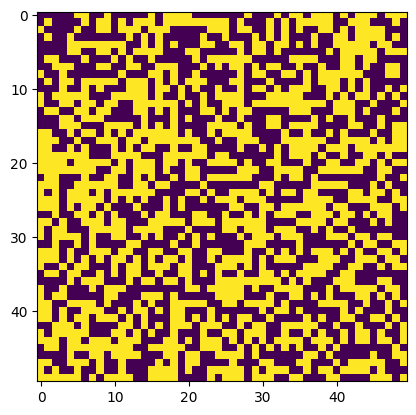

In [21]:
# Initial configuration of 50x50 Ising lattice
mat=createArray(50)
plt.imshow(mat)

### Near critical state
Now, run the MC simulation for 3000 steps at a temperature near the critical temp (2.27).

After simulation, most of the particles have the same spin (spin-up in the plot below, as shown by the yellow), and clusters of particles with spin-down emerge (purple). The average size of the clusters correspond to the correlation length, which is an important statistical quantity. 

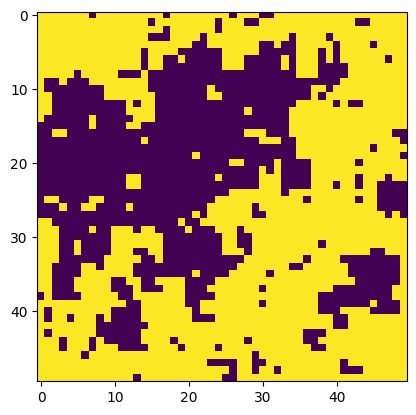

In [22]:
simulate(mat,2.3,3000)
plt.imshow(mat)

### High temperature state

At high temperatures, we see that the configuration after many simulations looks similar to the initial state, as expected. At high T, structures do not form.

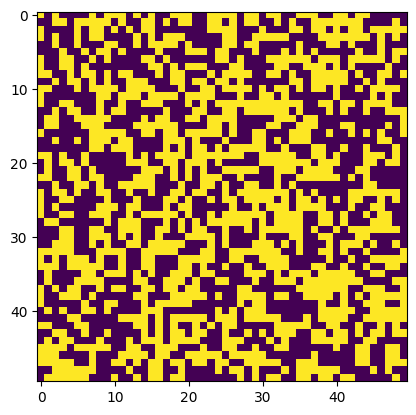

In [23]:
# High temperature simulation of 50x50 Ising lattice
mat=createArray(50)
simulate(mat,9.3,3000)
plt.imshow(mat)

### Low temperature state

At low tempeartures, spins of the particles tend to align very quickly, since aligned spins lead to the lowest energy state. Even after only 30 iteration, we have a nearly uniform state, with some fluctuations.

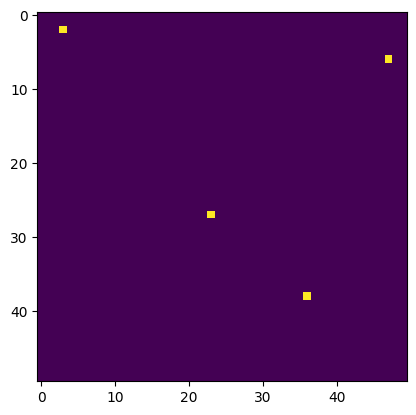

In [24]:
# Low temperature simulation of 50x50 Ising lattice
mat=createArray(50)
simulate(mat,1.2,30)
plt.imshow(mat)

## Generate training and validation sets

To generate the configurations for the dataset, need to decide how long to run the simulations. The goal is to save the configurations once they have "thermalized". One way to check for this is to monitor the average particle energy throughout the simulations to determine when it reaches an equilibrium value. Doing so shows that perfoming 1000 iterations would likely produce a thermalized configuration.

In [29]:
steps=2000
mat_lowT=createArray(20)
mat_critT=createArray(20)
mat_highT=createArray(20)

avgE_lowT = np.zeros(steps)
avgE_critT = np.zeros(steps)
avgE_highT = np.zeros(steps)
for step in tqdm(range(steps)):
    avgE_lowT[step]=iterateWolff(mat_lowT,1.8,True)
    avgE_critT[step]=iterateWolff(mat_critT,2.3,True)
    avgE_highT[step]=iterateWolff(mat_highT,3.1,True)
    #avgE[step]=iterate(mat,2.1,True)

  1%|          | 22/2000 [00:00<00:42, 46.73it/s] 

100%|██████████| 2000/2000 [00:44<00:00, 45.26it/s] 


Text(0, 0.5, 'Avg particle energy')

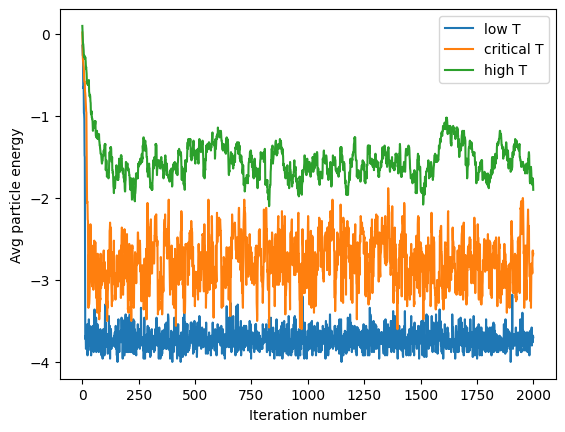

In [26]:
plt.plot(avgE_lowT, label = "low T")
plt.plot(avgE_critT,label = "critical T")
plt.plot(avgE_highT,label = "high T")
plt.legend(loc="upper right")
plt.xlabel("Iteration number")
plt.ylabel("Avg particle energy")

Now create a list of temperatures for which to perform simulations. I use a denser sampling of temperatures near the critical temperature.

Produce 500 samples per temperature value for a system size of 20x20.

In [27]:
Temps = np.concatenate((np.arange(1.5,3.2,0.1),np.arange(1.75,3.05,0.1)))

I invoke a parallelization of the simulations to generate them more quickly.

In [ ]:
%%time
samples = 500
L=20
steps = 1000
jobs=zip(Temps,repeat(L),repeat(steps),repeat(samples),repeat(train_path))
p = mp.Pool(4)
p.starmap(generateSamples, jobs)
p.close()
p.join()

For the validation set, generate 100 configurations for each temp.

In [125]:
%%time
samples = 100
L=20
steps = 1000
jobs=zip(Temps,repeat(L),repeat(steps),repeat(samples),repeat(valid_path))
p = mp.Pool(4)
p.starmap(generateSamples, jobs)
p.close()
p.join()

CPU times: user 18.6 ms, sys: 7.67 ms, total: 26.2 ms
Wall time: 125 ms


### Test set for a triangular lattice
To see how well our neural net generalizes, we also generate a test set of Ising configurations on a triangular lattice. The goal will be to predict the critical temperature, which takes the value of ~3.65, after only being trained on the square lattice dataset.

In [126]:
tri_test_path = '../../data/Ising/testTri/'

In [127]:
Temps_tri = np.arange(2.5,4.5,0.1)

In [130]:
samples = 100
L=20
steps = 1000
jobs=zip(Temps_tri,repeat(L),repeat(steps),repeat(samples),repeat(tri_test_path))
p = mp.Pool(4)
p.starmap(generateSamplesTri, jobs)
p.close()
p.join()

### Load and plot a generated sample
Just to check a sample output, load and plot it.

In [138]:
data_files=os.listdir(f"{valid_path}/low")

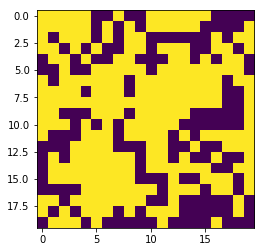

In [140]:
sampleMat=np.load(os.path.join(f"{valid_path}/low",data_files[0]))
plt.imshow(sampleMat)

# All done!
Now all datasets have been generated and we an can train our neural nets!

## Calculate correlations
Currently working on the statistical analysis... more to come!

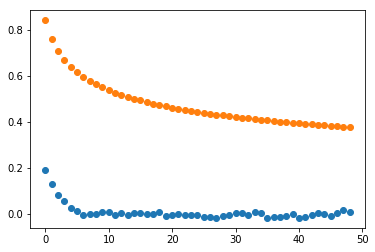

In [45]:
corr = np.zeros(int(100/2))
for i in range(1,int(100/2)):
    _,corr[i] = calcCorr(mat,100,i)

corr_theory = np.fromfunction(lambda i : (i+1.0)**-0.25, shape=(50,),dtype=float)
plt.plot(corr[1:],'o')
plt.plot(corr_theory[1:],'o')